In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import torch
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import eye
from pathlib import Path
from functools import partial
%matplotlib inline

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
path = Path('data/cora')

In [4]:
paper_features_label = np.genfromtxt(path/'cora.content', dtype=np.str)
paper_features_label

/tmp/ipykernel_30214/2440406101.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paper_features_label = np.genfromtxt(path/'cora.content', dtype=np.str)


array([['31336', '0', '0', ..., '0', '0', 'Neural_Networks'],
       ['1061127', '0', '0', ..., '0', '0', 'Rule_Learning'],
       ['1106406', '0', '0', ..., '0', '0', 'Reinforcement_Learning'],
       ...,
       ['1128978', '0', '0', ..., '0', '0', 'Genetic_Algorithms'],
       ['117328', '0', '0', ..., '0', '0', 'Case_Based'],
       ['24043', '0', '0', ..., '0', '0', 'Neural_Networks']],
      dtype='<U22')

In [5]:
features = csr_matrix(paper_features_label[:, 1:-1], dtype=np.float32)
labels = paper_features_label[:, -1]
lbl2idx = {k:v for v,k in enumerate(sorted(np.unique(labels)))}
labels = [lbl2idx[e] for e in labels]
labels[:5]

[2, 5, 4, 4, 3]

In [6]:
papers = paper_features_label[:,0].astype(np.int32)
papers

array([  31336, 1061127, 1106406, ..., 1128978,  117328,   24043],
      dtype=int32)

In [7]:
paper2idx = {k:v for v,k in enumerate(papers)}
edges = np.genfromtxt(path/'cora.cites', dtype=np.int32)
edges = np.asarray([paper2idx[e] for e in edges.flatten()], np.int32).reshape(edges.shape)
edges

array([[ 163,  402],
       [ 163,  659],
       [ 163, 1696],
       ...,
       [1887, 2258],
       [1902, 1887],
       [ 837, 1686]], dtype=int32)

In [8]:
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(len(labels), len(labels)), dtype=np.float32)

adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [9]:
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [10]:
features = normalize(features)

In [11]:
adj = normalize(adj + eye(adj.shape[0])) #Normalizing for removing gradient vanishing and exploding problem

In [12]:
adj = torch.FloatTensor(adj.todense())
features = torch.FloatTensor(features.todense())
labels = torch.LongTensor(labels)

In [13]:
np.random.seed(34)
n_train = 200
n_val = 300
n_test = len(features) - n_train - n_val
idxs = np.random.permutation(len(features))
idx_train = torch.LongTensor(idxs[:n_train])
idx_val   = torch.LongTensor(idxs[n_train:n_train+n_val])
idx_test  = torch.LongTensor(idxs[n_train+n_val:])

In [14]:
adj = adj.to(device)
features = features.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [15]:
class GraphConvolution(Module):
    
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ') '
    
    
    
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [16]:
n_labels = labels.max().item() + 1
n_features = features.shape[1]
n_labels, n_features

(7, 1433)

In [17]:
torch.manual_seed(34)

model = GCN(nfeat=n_features,
            nhid=20, #hidden = 16
            nclass=n_labels,
            dropout=0.5) #dropout = 0.5

model = model.to(device)
optimizer = optim.Adam(model.parameters(),
                       lr=0.001, weight_decay=5e-4)


def step():
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss = F.nll_loss(output[idx_train], labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    
    return loss.item(), acc

def evaluate(idx):
    model.eval()
    output = model(features, adj)
    loss = F.nll_loss(output[idx], labels[idx])
    acc = accuracy(output[idx], labels[idx])
    
    return loss.item(), acc

In [18]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [19]:
epochs = 1000
print_steps = 100
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for i in tnrange(epochs):
    tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]
    
    if((i+1)%print_steps) == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]
        
        print('Epochs: {}, Train Loss: {:.3f}, Train Acc: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}'.format(i, tl, ta, vl, va))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs: 0, Train Loss: 1.984, Train Acc: 0.095, Validation Loss: 1.937, Validation Acc: 0.063
Epochs: 99, Train Loss: 1.838, Train Acc: 0.245, Validation Loss: 1.824, Validation Acc: 0.320
Epochs: 199, Train Loss: 1.699, Train Acc: 0.365, Validation Loss: 1.731, Validation Acc: 0.397
Epochs: 299, Train Loss: 1.515, Train Acc: 0.695, Validation Loss: 1.603, Validation Acc: 0.597
Epochs: 399, Train Loss: 1.280, Train Acc: 0.760, Validation Loss: 1.430, Validation Acc: 0.640
Epochs: 499, Train Loss: 1.059, Train Acc: 0.810, Validation Loss: 1.260, Validation Acc: 0.680
Epochs: 599, Train Loss: 0.886, Train Acc: 0.865, Validation Loss: 1.127, Validation Acc: 0.723
Epochs: 699, Train Loss: 0.754, Train Acc: 0.920, Validation Loss: 1.023, Validation Acc: 0.780
Epochs: 799, Train Loss: 0.652, Train Acc: 0.955, Validation Loss: 0.945, Validation Acc: 0.803
Epochs: 899, Train Loss: 0.570, Train Acc: 0.960, Validation Loss: 0.884, Validation Acc: 0.823
Epochs: 999, Train Loss: 0.502, Train Acc: 

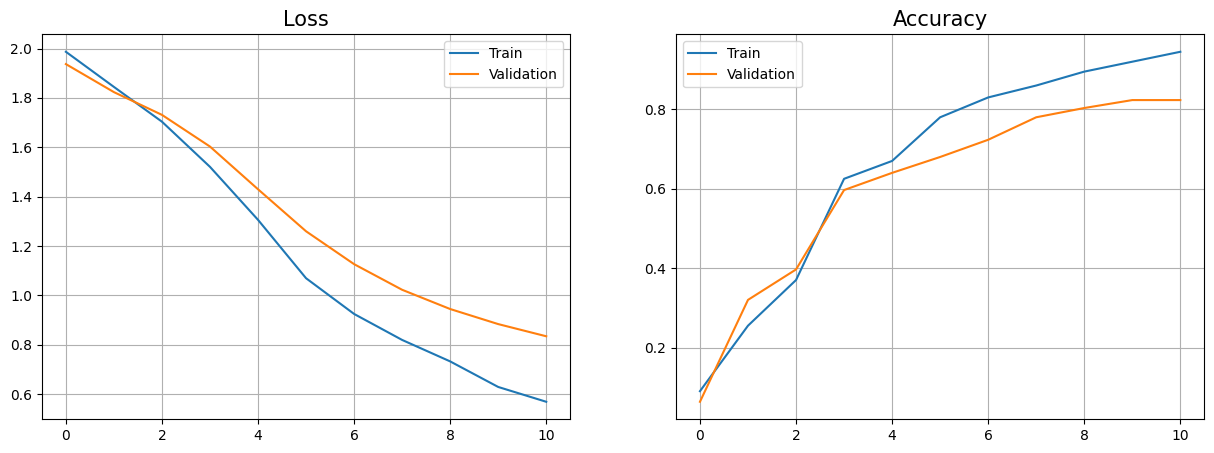

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

# moved to cpu
# train_acc = [i.cpu() for i in train_acc]
# val_acc = [i.cpu() for i in val_acc]

# train_loss = np.array(train_loss)
# train_acc = np.array(train_acc)
# val_loss = np.array(val_loss)
# val_acc = np.array(val_acc) 

# axes[0].plot(train_loss, label='train')
# axes[0].plot(val_loss, label='validation')
# axes[0].set_xlabel('Epochs')
# axes[0].set_ylabel('Loss')
# axes[0].legend()

# axes[1].plot(train_acc, label='train')
# axes[1].plot(val_acc, label='validation')
# axes[1].set_xlabel('Epochs')
# axes[1].set_ylabel('Accuracy')
# axes[1].legend()

# plt.show()

# moved to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]

ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
axes[1].plot(train_acc[::print_steps] + [train_acc[-1]], label='Train')
axes[1].plot(val_acc, label='Validation')
axes[0].grid()
axes[1].grid()

for ax, t in zip(axes, ['Loss','Accuracy']): 
    ax.legend(), ax.set_title(t, size=15)

In [21]:
output = model(features, adj)

In [26]:
samples = 13
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v:k for k,v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
df

,Real,Pred
0,Rule_Learning,Rule_Learning
1,Theory,Theory
2,Genetic_Algorithms,Genetic_Algorithms
3,Theory,Theory
4,Neural_Networks,Reinforcement_Learning
5,Theory,Theory
6,Neural_Networks,Probabilistic_Methods
7,Neural_Networks,Neural_Networks
8,Genetic_Algorithms,Genetic_Algorithms
9,Probabilistic_Methods,Probabilistic_Methods
